In [1]:
import torch
import torchaudio
from ml4gw.constants import PI
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

In [2]:
def buttap(N):
    """Return (z,p,k) for analog prototype of Nth-order Butterworth filter.

    The filter will have an angular (e.g., rad/s) cutoff frequency of 1.

    See Also
    --------
    butter : Filter design function using this prototype

    """
    if abs(int(N)) != N:
        raise ValueError("Filter order must be a nonnegative integer")
    z = torch.tensor([])
    m = torch.arange(-N + 1, N, 2)
    # Middle value is 0 to ensure an exactly real pole
    p = -torch.exp(1j * PI * m / (2 * N))
    k = 1
    return z, p, k


def _relative_degree(z, p):
    """
    Return relative degree of transfer function from zeros and poles
    """
    degree = len(p) - len(z)
    if degree < 0:
        raise ValueError(
            "Improper transfer function. "
            "Must have at least as many poles as zeros."
        )
    else:
        return degree


def lp2lp_zpk(z, p, k, wo=1.0):
    z = torch.atleast_1d(z)
    p = torch.atleast_1d(p)
    wo = float(wo)  # Avoid int wraparound

    degree = _relative_degree(z, p)

    # Scale all points radially from origin to shift cutoff frequency
    z_lp = wo * z
    p_lp = wo * p

    # Each shifted pole decreases gain by wo, each shifted zero increases it.
    # Cancel out the net change to keep overall gain the same
    k_lp = k * wo**degree

    return z_lp, p_lp, k_lp


def lp2hp_zpk(z, p, k, wo=1.0):
    z = torch.atleast_1d(z)
    p = torch.atleast_1d(p)
    wo = float(wo)

    degree = _relative_degree(z, p)

    # Invert positions radially about unit circle to convert LPF to HPF
    # Scale all points radially from origin to shift cutoff frequency
    z_hp = wo / z
    p_hp = wo / p

    # If lowpass had zeros at infinity, inverting moves them to origin.
    z_hp = torch.cat((z_hp, torch.zeros(degree)))

    # Cancel out gain change caused by inversion
    k_hp = k * torch.real(torch.prod(-z) / torch.prod(-p))

    return z_hp, p_hp, k_hp


def lp2bp_zpk(z, p, k, wo=1.0, bw=1.0):
    z = torch.atleast_1d(z)
    p = torch.atleast_1d(p)
    wo = float(wo)
    bw = float(bw)

    degree = _relative_degree(z, p)

    # Scale poles and zeros to desired bandwidth
    z_lp = z * bw / 2
    p_lp = p * bw / 2

    # Square root needs to produce complex result, not NaN
    z_lp = z_lp.astype(complex)
    p_lp = p_lp.astype(complex)

    # Duplicate poles and zeros and shift from baseband to +wo and -wo
    z_bp = torch.concatenate(
        (
            z_lp + torch.sqrt(z_lp**2 - wo**2),
            z_lp - torch.sqrt(z_lp**2 - wo**2),
        )
    )
    p_bp = torch.concatenate(
        (
            p_lp + torch.sqrt(p_lp**2 - wo**2),
            p_lp - torch.sqrt(p_lp**2 - wo**2),
        )
    )

    # Move degree zeros to origin, leaving degree zeros at infinity for BPF
    z_bp = torch.cat((z_bp, torch.zeros(degree)))

    # Cancel out gain change from frequency scaling
    k_bp = k * bw**degree

    return z_bp, p_bp, k_bp


def lp2bs_zpk(z, p, k, wo=1.0, bw=1.0):
    z = torch.atleast_1d(z)
    p = torch.atleast_1d(p)
    wo = float(wo)
    bw = float(bw)

    degree = _relative_degree(z, p)

    # Invert to a highpass filter with desired bandwidth
    z_hp = (bw / 2) / z
    p_hp = (bw / 2) / p

    # Square root needs to produce complex result, not NaN
    z_hp = z_hp.astype(complex)
    p_hp = p_hp.astype(complex)

    # Duplicate poles and zeros and shift from baseband to +wo and -wo
    z_bs = torch.concatenate(
        (
            z_hp + torch.sqrt(z_hp**2 - wo**2),
            z_hp - torch.sqrt(z_hp**2 - wo**2),
        )
    )
    p_bs = torch.concatenate(
        (
            p_hp + torch.sqrt(p_hp**2 - wo**2),
            p_hp - torch.sqrt(p_hp**2 - wo**2),
        )
    )

    # Move any zeros that were at infinity to the center of the stopband
    z_bs = torch.cat((z_bs, torch.full(degree, +1j * wo)))
    z_bs = torch.cat((z_bs, torch.full(degree, -1j * wo)))

    # Cancel out gain change caused by inversion
    k_bs = k * torch.real(torch.prod(-z) / torch.prod(-p))

    return z_bs, p_bs, k_bs


def _validate_fs(fs, allow_none=True):
    """
    Check if the given sampling frequency is a scalar and raises an exception
    otherwise. If allow_none is False, also raises an exception for none
    sampling rates. Returns the sampling frequency as float or none if the
    input is none.
    """
    if fs is None:
        if not allow_none:
            raise ValueError("Sampling frequency can not be none.")
    else:  # should be float
        if size(fs) != 1:
            raise ValueError("Sampling frequency fs must be a single scalar.")
        fs = float(fs)
    return fs


def bilinear_zpk(z, p, k, fs):
    z = torch.atleast_1d(z)
    p = torch.atleast_1d(p)

    fs = _validate_fs(fs, allow_none=False)

    degree = _relative_degree(z, p)

    fs2 = 2.0 * fs

    # Bilinear transform the poles and zeros
    z_z = (fs2 + z) / (fs2 - z)
    p_z = (fs2 + p) / (fs2 - p)

    # Any zeros that were at infinity get moved to the Nyquist frequency
    z_z = torch.cat((z_z, -torch.ones(degree)))

    # Compensate for gain change
    k_z = k * torch.real(torch.prod(fs2 - z) / torch.prod(fs2 - p))

    return z_z, p_z, k_z


def zpk2tf(z, p, k):
    z = torch.atleast_1d(z)
    k = torch.atleast_1d(k)
    if len(z.shape) > 1:
        temp = poly(z[0])
        b = torch.empty((z.shape[0], z.shape[1] + 1), temp.dtype.char)
        if len(k) == 1:
            k = [k[0]] * z.shape[0]
        for i in range(z.shape[0]):
            b[i] = k[i] * poly(z[i])
    else:
        b = k * poly(z)
    a = torch.atleast_1d(poly(p))

    return b, a


def size(t):
    try:
        shape = t.shape
        if type(shape) == torch.Size:
            return torch.prod(torch.tensor(shape)).item()
        else:
            return np.prod(shape)
    except AttributeError:
        return 1


def poly(seq):
    """
    Find the coefficients of a polynomial with given sequence of roots.
    """
    seq = torch.atleast_1d(seq)
    if len(seq) == 0:
        return torch.tensor([1.0], dtype=torch.float64)
    else:
        p = torch.tensor([1.0, -seq[0]], dtype=torch.complex128)
        for s in seq[1:]:
            p = torchaudio.functional.convolve(
                p, torch.tensor([1.0, -s], dtype=torch.complex128)
            )
        return p


def iirfilter(N, Wn, btype="low", analog=False, fs=None):
    z, p, k = buttap(N)

    if not analog:
        if torch.any(Wn <= 0) or torch.any(Wn >= 1):
            if fs is not None:
                raise ValueError(
                    "Digital filter critical frequencies must "
                    f"be 0 < Wn < fs/2 (fs={fs} -> fs/2={fs/2})"
                )
            raise ValueError(
                "Digital filter critical frequencies " "must be 0 < Wn < 1"
            )
        fs = 2.0
        warped = 2 * fs * torch.tan(PI * Wn / fs)
    else:
        warped = Wn

    # transform to lowpass, bandpass, highpass, or bandstop
    if btype in ("lowpass", "highpass", "low", "high"):
        if size(Wn) != 1:
            raise ValueError(
                "Must specify a single critical frequency Wn "
                "for lowpass or highpass filter"
            )

        if btype == "lowpass" or btype == "low":
            z, p, k = lp2lp_zpk(z, p, k, wo=warped)
        elif btype == "highpass" or btype == "high":
            z, p, k = lp2hp_zpk(z, p, k, wo=warped)
    elif btype in ("bandpass", "bandstop"):
        try:
            bw = warped[1] - warped[0]
            wo = torch.sqrt(warped[0] * warped[1])
        except IndexError as e:
            raise ValueError(
                "Wn must specify start and stop frequencies for "
                "bandpass or bandstop filter"
            ) from e
        if btype == "bandpass":
            z, p, k = lp2bp_zpk(z, p, k, wo=wo, bw=bw)
        elif btype == "bandstop":
            z, p, k = lp2bs_zpk(z, p, k, wo=wo, bw=bw)
    else:
        raise NotImplementedError(f"'{btype}' not implemented in iirfilter.")

    # Find discrete equivalent if necessary
    if not analog:
        z, p, k = bilinear_zpk(z, p, k, fs=fs)

    # Transform to proper out type (numer-denom)
    return zpk2tf(z, p, k)

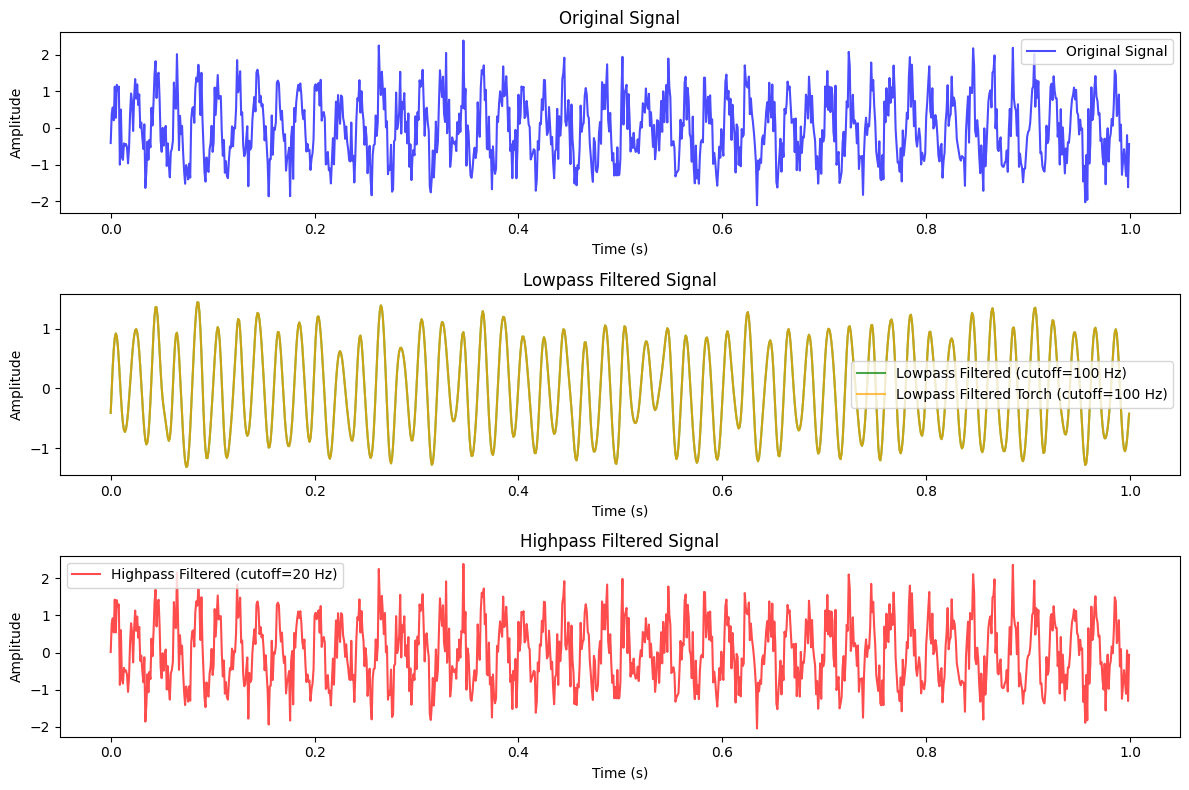

In [3]:
# Function to create a Butterworth filter
def butter_filter(data, cutoff, fs, order, btype):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data, b, a


def butter_filter_torch(data, cutoff, fs, order, btype):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = iirfilter(order, normal_cutoff, btype=btype, analog=False, fs=fs)
    filtered_data = filtfilt(b, a, data)
    return filtered_data, b, a


# Parameters for signal generation
fs = 1000
t = np.linspace(0, 1.0, fs, endpoint=False)
tone_freq = 50
noise_amplitude = 0.5


signal = np.sin(2 * np.pi * tone_freq * t)
noise = noise_amplitude * np.random.normal(size=t.shape)
combined_signal = signal + noise

low_cutoff = 100
high_cutoff = 20
order = 4


lowpass_filtered, b_lp, a_lp = butter_filter(
    combined_signal, low_cutoff, fs, order, btype="low"
)
lowpass_filtered_torch, b_lp_torch, a_lp_torch = butter_filter_torch(
    torch.tensor(combined_signal),
    torch.tensor(low_cutoff),
    torch.tensor(fs),
    order,
    btype="low",
)


highpass_filtered, b_hp, a_hp = butter_filter(
    combined_signal, high_cutoff, fs, order, btype="high"
)
highpass_filtered_torch, b_hp_torch, a_hp_torch = butter_filter_torch(
    torch.tensor(combined_signal),
    torch.tensor(high_cutoff),
    torch.tensor(fs),
    order,
    btype="high",
)

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, combined_signal, label="Original Signal", color="blue", alpha=0.7)
plt.title("Original Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()


plt.subplot(3, 1, 2)
plt.plot(
    t,
    lowpass_filtered,
    label=f"Lowpass Filtered (cutoff={low_cutoff} Hz)",
    color="green",
    alpha=0.7,
)
plt.plot(
    t,
    lowpass_filtered_torch.real,
    label=f"Lowpass Filtered Torch (cutoff={low_cutoff} Hz)",
    color="orange",
    alpha=0.7,
)
plt.title("Lowpass Filtered Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()


plt.subplot(3, 1, 3)
plt.plot(
    t,
    highpass_filtered,
    label=f"Highpass Filtered (cutoff={high_cutoff} Hz)",
    color="red",
    alpha=0.7,
)
plt.title("Highpass Filtered Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

plt.tight_layout()
plt.show()

In [4]:
print(
    "max error in highpass: ",
    np.abs(highpass_filtered_torch.real - highpass_filtered).max(),
)
print("min value in highpass: ", np.abs(highpass_filtered_torch.real).min())
print(
    "max error in lowpass: ",
    np.abs(lowpass_filtered_torch.real - lowpass_filtered).max(),
)
print("min value in lowpass: ", np.abs(lowpass_filtered_torch.real).min())

max error in highpass:  2.1977146058560493e-07
min value in highpass:  0.005121985830943587
max error in lowpass:  5.481906106830081e-07
min value in lowpass:  0.0013829652556469518
